In [3]:
import sys

import pydensecrf.densecrf as dcrf

from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, unary_from_softmax

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import numpy as np

In [242]:
W, H, NLABELS = [512,512,2]

#path = '/Users/apple/Developer/AcuteTBI_seg/result_analysis'
path = '/home/hemingy/Developer/AcuteTBI_seg/result_analysis'
subject = '76'

prob_maps = sorted(glob.glob(os.path.join(path, subject, '*prob.png')))
brain_imgs = sorted(glob.glob(os.path.join(path, subject, '*brain.png')))
annot_imgs = sorted(glob.glob(os.path.join(path, subject, '*annot.png')))
pred_imgs = sorted(glob.glob(os.path.join(path, subject, '*pred.png')))
mask_imgs = sorted(glob.glob(os.path.join(path, subject, '*mask.png')))
saliency_imgs = sorted(glob.glob(os.path.join(path, subject, '*saliency.png')))
prob_maps = sorted(glob.glob(os.path.join(path, subject, '*prob.png')))
brain_imgs[-5]

'/home/hemingy/Developer/AcuteTBI_seg/result_analysis/76/5_0.287brain.png'

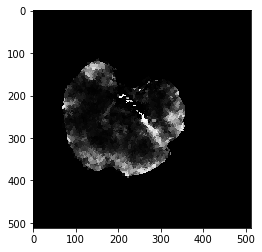

In [229]:
index = -3
probs = mpimg.imread(prob_maps[index])
brain = mpimg.imread(brain_imgs[index])
annot = mpimg.imread(annot_imgs[index])
pred = mpimg.imread(pred_imgs[index])
mask = mpimg.imread(mask_imgs[index])
saliency = mpimg.imread(saliency_imgs[index])
img = saliency

plt.imshow(probs,cmap='gray')

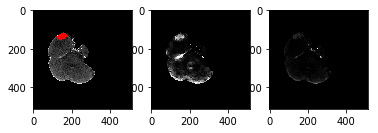

In [234]:
index = -5
probs = mpimg.imread(prob_maps[index])
brain = mpimg.imread(brain_imgs[index])
annot = mpimg.imread(annot_imgs[index])
pred = mpimg.imread(pred_imgs[index])
mask = mpimg.imread(mask_imgs[index])
saliency = mpimg.imread(saliency_imgs[index])
img = brain

plt.subplot(1,3,1);plt.imshow(annot,cmap='gray')
plt.subplot(1,3,2);plt.imshow(probs,cmap='gray')
plt.subplot(1,3,3);plt.imshow(saliency,cmap='gray')
if len(img.shape)<3:
    img = np.expand_dims(img, axis=-1)

probs = np.tile(probs[np.newaxis,:,:],(2,1,1))
probs[1,:,:] = 1 - probs[0,:,:]

# The input should be the negative of the logarithm of probability values
# Look up the definition of the softmax_to_unary for more information
unary = unary_from_softmax(probs)

# The inputs should be C-continious -- we are using Cython wrapper
unary = np.ascontiguousarray(unary)

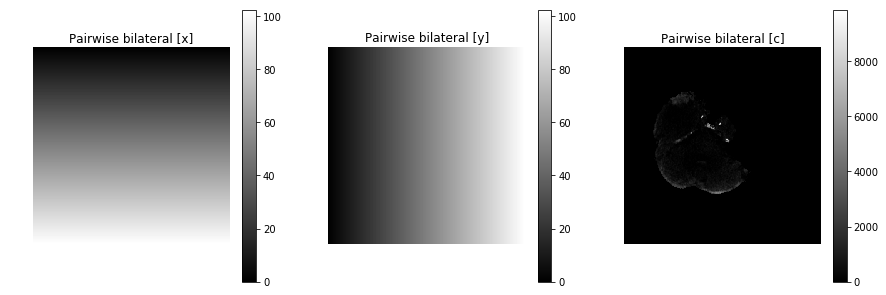

In [76]:
# Create the pairwise bilateral term from the above image.
# The two `s{dims,chan}` parameters are model hyper-parameters defining
# the strength of the location and image content bilaterals, respectively.
pairwise_energy = create_pairwise_bilateral(sdims=(5,5), schan=(0.0001,), img=img, chdim=2)

# pairwise_energy now contains as many dimensions as the DenseCRF has features,
# which in this case is 3: (x,y,channel1)

img_en = pairwise_energy.reshape((-1, H, W))  # Reshape just for plotting
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img_en[0],cmap='gray'); plt.title('Pairwise bilateral [x]'); plt.axis('off'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(img_en[1],cmap='gray'); plt.title('Pairwise bilateral [y]'); plt.axis('off'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(img_en[2],cmap='gray'); plt.title('Pairwise bilateral [c]'); plt.axis('off'); plt.colorbar();

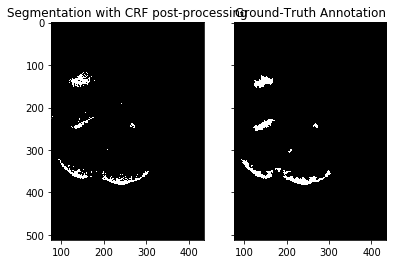

In [85]:
d = dcrf.DenseCRF2D(W, H, NLABELS)
d.setUnaryEnergy(unary)


pairwise_energy =  create_pairwise_bilateral(sdims=(10,10), schan=(0.00001,), img=img, chdim=2)

d.addPairwiseEnergy(pairwise_energy , compat=100,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)


Q, tmp1, tmp2 = d.startInference()
for _ in range(100):
    d.stepInference(Q, tmp1, tmp2)
kl1 = d.klDivergence(Q) / (H*W)
map_soln1 = np.argmax(Q, axis=0).reshape((H,W))

res = np.argmax(Q, axis=0).reshape((brain.shape[0], brain.shape[1]))

cmap = plt.get_cmap('bwr')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(1-res, cmap='gray')
ax1.set_title('Segmentation with CRF post-processing')
probability_graph = ax2.imshow(mask,cmap='gray')
ax2.set_title('Ground-Truth Annotation')
plt.show()



In [252]:
import scipy.misc
final_pred = 1-res
final_pred = final_pred.astype(np.float)
m = np.zeros(annot.shape)
m[:,:,0]=1.0
x = (m==annot)
gt = np.all(x, axis=(2))

dice = 2*np.sum(mask*gt)/np.sum(mask+gt)
dice_crf = 2*np.sum(final_pred*gt)/np.sum(final_pred+gt)
#dice = np.sum(mask*pred)/np.sum(np.any([mask,final_pred], axis=0))
dice_crf
scipy.misc.imsave(slice_index+'crf.jpg', final_pred)

NameError: name 'final_result' is not defined

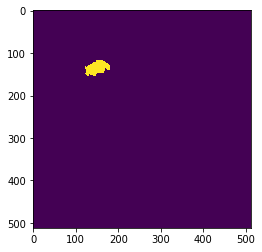

In [251]:
truth = np.zeros(annot.shape)
truth[:,:,0]=1.0
x = (truth==annot)
inter = np.all(x, axis=(2))
plt.imshow(inter)
np.sum(mask*inter)


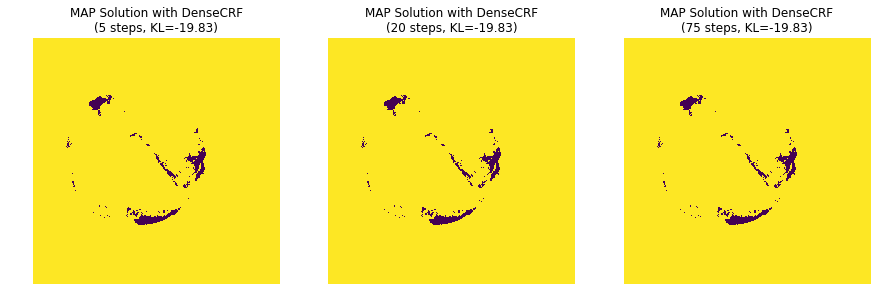

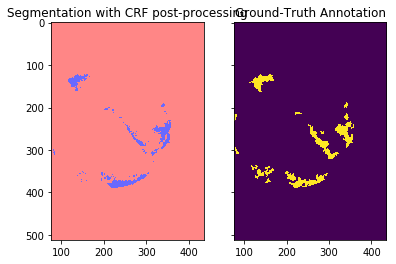

In [56]:
d = dcrf.DenseCRF2D(W, H, NLABELS)
d.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
pairwise_energy =  create_pairwise_bilateral(sdims=(15,15), schan=(0.0001,), img=img, chdim=2)

d.addPairwiseEnergy(pairwise_energy , compat=20,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)


Q, tmp1, tmp2 = d.startInference()
for _ in range(5):
    d.stepInference(Q, tmp1, tmp2)
kl1 = d.klDivergence(Q) / (H*W)
map_soln1 = np.argmax(Q, axis=0).reshape((H,W))


for _ in range(20):
    d.stepInference(Q, tmp1, tmp2)
kl2 = d.klDivergence(Q) / (H*W)
map_soln2 = np.argmax(Q, axis=0).reshape((H,W))

for _ in range(50):
    d.stepInference(Q, tmp1, tmp2)
kl3 = d.klDivergence(Q) / (H*W)
map_soln3 = np.argmax(Q, axis=0).reshape((H,W))

img_en = pairwise_energy.reshape((-1, H, W))  # Reshape just for plotting
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(map_soln1);
plt.title('MAP Solution with DenseCRF\n(5 steps, KL={:.2f})'.format(kl1)); plt.axis('off');
plt.subplot(1,3,2); plt.imshow(map_soln2);
plt.title('MAP Solution with DenseCRF\n(20 steps, KL={:.2f})'.format(kl2)); plt.axis('off');
plt.subplot(1,3,3); plt.imshow(map_soln3);
plt.title('MAP Solution with DenseCRF\n(75 steps, KL={:.2f})'.format(kl3)); plt.axis('off');


res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))

cmap = plt.get_cmap('bwr')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
ax1.set_title('Segmentation with CRF post-processing')
probability_graph = ax2.imshow(mask)
ax2.set_title('Ground-Truth Annotation')
plt.show()